# 04. Dynamic Flux Balance Analysis

The code below is adapted from the dynamic flux balance analysis page of the [copbrapy documentation website](https://cobrapy.readthedocs.io/en/latest/dfba.html) with glucose uptake data from the article: <br/>
Van Wezel, G.P., Mahr, K., König, M., Traag, B.A., Pimentel-Schmitt, E.F., Willimek, A. and Titgemeyer, F. <br/> (2005), GlcP constitutes the major glucose uptake system of Streptomyces coelicolor A3(2).<br/> Molecular Microbiology, 55: 624-636. https://doi.org/10.1111/j.1365-2958.2004.04413.x

In [1]:
#call load_model
%run 00load_model.ipynb

In [6]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -1.32 * glucose / (0.137 + glucose) #Glucose uptake of S. coelicolor according to Van Wezel et al.
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(model, ['BIOMASS_SCO_tRNA', 'EX_glc__D_e'], ['max','max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    return fluxes


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [3]:
ts = np.linspace(0, 15, 20)  # Desired integration resolution and interval
y0 = [0.1, 10]


sol = solve_ivp(
    fun=dynamic_system,
    events=[infeasible_event],
    t_span=(ts.min(), ts.max()),
    y0=y0,
    t_eval=ts,
    rtol=1e-6,
    atol=1e-8,
    method='BDF'
    )

In [4]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 69
     njev: 1
      nlu: 9
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.78947368,  1.57894737,  2.36842105,  3.15789474,
        3.94736842,  4.73684211,  5.52631579,  6.31578947,  7.10526316,
        7.89473684,  8.68421053,  9.47368421, 10.26315789, 11.05263158,
       11.84210526, 12.63157895, 13.42105263, 14.21052632, 15.        ])
 t_events: [array([], dtype=float64)]
        y: array([[ 0.1       ,  0.11054846,  0.12220745,  0.13509353,  0.14933519,
         0.16507415,  0.18246671,  0.20168525,  0.22291963,  0.24637887,
         0.27229306,  0.30091496,  0.33252189,  0.3674175 ,  0.40593328,
         0.44842939,  0.49529558,  0.54694786,  0.60382292,  0.66636273],
       [10.        ,  9.89187278,  9.77236076,  9.6402687 ,  9.49427877,
         9.33293754,  9.1546418 ,  8.95762339,  8.73993429,  8.4994296 ,
         8.233748  ,  7.94029433,  7.61622082

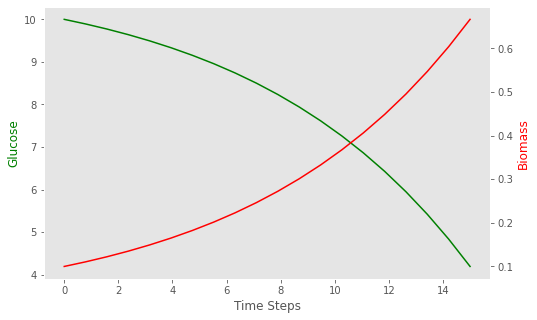

In [5]:
plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 1], color='g')
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 0], color='r')

ax.set_xlabel('Time Steps')
ax.set_ylabel('Glucose', color='g')
ax.grid(False)
ax2.set_ylabel('Biomass', color='r')
ax2.grid(False)